In [8]:
import numpy as np
import tensorflow as tf
import keras
import os
import sys
from tqdm import tqdm
import time
import keras.backend as K

In [9]:
sys.path.append('..')

In [10]:
import nets
from Data import datagen
import importlib 
importlib.reload(datagen)  # Python 3.4+

<module 'Data.datagen' from '/home/keondopark/sleep/JupyterNotebooks/../Data/datagen.py'>

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs 1 Logical GPUs


In [12]:
np.random.seed(1)

In [13]:
PROCESSED_DATA_PATH = os.path.join('/home','aiot','data','origin_npy')
save_signals_path_SC = os.path.join(PROCESSED_DATA_PATH,'signals_SC_filtered')
save_annotations_path_SC = os.path.join(PROCESSED_DATA_PATH,'annotations_SC')
save_signals_path_ST = os.path.join(PROCESSED_DATA_PATH,'signals_ST_filtered')
save_annotations_path_ST = os.path.join(PROCESSED_DATA_PATH,'annotations_ST')

save_signals_path_SC_seq = os.path.join(PROCESSED_DATA_PATH,'signals_SC_seq')
save_annotations_path_SC_seq = os.path.join(PROCESSED_DATA_PATH,'annotations_SC_seq')
save_signals_path_ST_seq = os.path.join(PROCESSED_DATA_PATH,'signals_ST_seq')
save_annotations_path_ST_seq = os.path.join(PROCESSED_DATA_PATH,'annotations_ST_seq')

In [14]:
def match_annotations_npy(dirname, filepath):
    filename = os.path.basename(filepath)
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filenames = [file for file in file_list if search_filename in file if file.endswith('.npy')]
    return filenames

In [15]:
dim_HT1D = (3000,1)
n_classes=6
epochs = 50
bs = 64
BASE_LEARNING_RATE = 1e-3
data_ratio = 0.25
PREV_CNT = 10
list_files_SC = [os.path.join(save_signals_path_SC, f) for f in os.listdir(save_signals_path_SC) if f.endswith('.npy')]
list_files_ST = [os.path.join(save_signals_path_ST, f) for f in os.listdir(save_signals_path_ST) if f.endswith('.npy')]

In [16]:
def read_csv_to_list(filepath):
    import csv
    with open(filepath, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        list_filepath = [row[0] for row in spamreader]
    return list_filepath

In [17]:
list_files_SC = [os.path.join(save_signals_path_SC, f) for f in os.listdir(save_signals_path_SC) if f.endswith('.npy')]
list_files_ST = [os.path.join(save_signals_path_ST, f) for f in os.listdir(save_signals_path_ST) if f.endswith('.npy')]

list_files_SC_seq = [os.path.join(save_signals_path_SC_seq, f) for f in os.listdir(save_signals_path_SC_seq) if f.endswith('.npy')]
list_files_ST_seq = [os.path.join(save_signals_path_ST_seq, f) for f in os.listdir(save_signals_path_ST_seq) if f.endswith('.npy')]

train_test_split = 0.7
split_cnt_SC = int(train_test_split * len(list_files_SC))
split_cnt_ST = int(train_test_split * len(list_files_ST))

include_SC = True
include_ST = True

list_files_train = []
list_files_test = []

list_seq_files_train = []
list_seq_files_test = []

list_ann_files_train = []
list_ann_files_test = []

list_ann_seq_files_train = []
list_ann_seq_files_test = []

if include_SC:
    list_files_SC_train = np.random.choice(list_files_SC[:split_cnt_SC], int(float(data_ratio) * split_cnt_SC), replace=False)
    list_files_train += list_files_SC_train.tolist()

    for f in list_files_SC_train:
        ann_file = match_annotations_npy(save_annotations_path_SC, f)
        list_ann_files_train.append(os.path.join(save_annotations_path_SC, ann_file[0]))

        list_seq_files_train.append(os.path.join(save_signals_path_SC_seq, os.path.basename(f)))
        list_ann_seq_files_train.append(os.path.join(save_annotations_path_SC_seq, ann_file[0]))
    
    list_files_test += list_files_SC[split_cnt_SC:]

    for f in list_files_SC[split_cnt_SC:]:
        ann_file = match_annotations_npy(save_annotations_path_SC, f)
        list_ann_files_test.append(os.path.join(save_annotations_path_SC, ann_file[0]))
        list_seq_files_test.append(os.path.join(save_signals_path_SC_seq, os.path.basename(f)))
        list_ann_seq_files_test.append(os.path.join(save_annotations_path_SC_seq, ann_file[0]))




if include_ST:
    list_files_ST_train = np.random.choice(list_files_ST[:split_cnt_ST], int(float(data_ratio) * split_cnt_ST), replace=False)
    list_files_train += list_files_ST_train.tolist()
    for f in list_files_ST_train:
        ann_file = match_annotations_npy(save_annotations_path_ST, f)
        list_ann_files_train.append(os.path.join(save_annotations_path_ST, ann_file[0]))
        list_seq_files_train.append(os.path.join(save_signals_path_ST_seq, os.path.basename(f)))
        list_ann_seq_files_train.append(os.path.join(save_annotations_path_ST_seq, ann_file[0]))

    list_files_test += list_files_ST[split_cnt_ST:]
    for f in list_files_ST[split_cnt_ST:]:
        ann_file = match_annotations_npy(save_annotations_path_ST, f)
        list_ann_files_test.append(os.path.join(save_annotations_path_ST, ann_file[0]))
        list_seq_files_test.append(os.path.join(save_signals_path_ST_seq, os.path.basename(f)))
        list_ann_seq_files_test.append(os.path.join(save_annotations_path_ST_seq, ann_file[0]))

# Generator for training the model predicting from single epoch
#train_generator = datagen.DataGenerator(list_files_train, list_ann_files_train, 
#                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=True)
test_generator = datagen.DataGenerator(list_files_test, list_ann_files_test, 
                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=False)

#train_generator2 = datagen.DataGenerator(list_seq_files_train, list_ann_seq_files_train, 
#                          batch_size=bs, dim=(PREV_CNT+1,) + dim_HT1D, n_classes=n_classes, shuffle=True)
test_generator2 = datagen.DataGenerator(list_seq_files_test, list_ann_seq_files_test, 
                          batch_size=bs, dim=(PREV_CNT+1,) + dim_HT1D, n_classes=n_classes, shuffle=False)

In [18]:
model = nets.Conv1DASPP_single()

In [19]:
x = np.random.random((1,3000,1))
x = tf.convert_to_tensor(x)
model(x)

2022-04-12 23:21:49.228689: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-12 23:21:49.834623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-04-12 23:21:50.759838: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-12 23:21:50.759884: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-04-12 23:21:50.760230: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-12 23:21:50.760293: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-12 23:21:50.779063: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.16520905, 0.16617137, 0.16486935, 0.16489288, 0.15868229,
        0.18017505]], dtype=float32)>

In [20]:
model.summary()

Model: "conv1daspp_single"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1daspp_layer (Conv1DASPP multiple                  3379456   
_________________________________________________________________
dense_1 (Dense)              multiple                  15366     
Total params: 3,394,822
Trainable params: 3,389,126
Non-trainable params: 5,696
_________________________________________________________________


In [21]:
def get_current_lr(epoch):
    lr = BASE_LEARNING_RATE
    for _ in range(epoch // 10):
        lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    optimizer.learning_rate = lr

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [23]:
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, '../tf_ckpt/ckpt_' + model.name, max_to_keep=1)

In [24]:
start_epoch = 0
#if manager.latest_checkpoint:
ckpt.restore(manager.latest_checkpoint)
start_epoch = ckpt.step.numpy()

In [25]:
os.listdir('../tf_ckpt/ckpt_'+model.name)

['ckpt-4.index', 'checkpoint', 'ckpt-4.data-00000-of-00001']

In [26]:
if manager.latest_checkpoint:
    print("Restore")

Restore


In [27]:
correct, total_cnt, total_loss = 0.0, 0.0, 0.0
start = time.time()
y_list, y_pred_list = [], []
for idx, (x, y) in enumerate(test_generator):
    y_pred = model(x, training=False)
    y_pred_cls = tf.math.argmax(y_pred, axis=-1)
    y_pred_list.append(y_pred_cls)
    correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
    total_cnt += y_pred.shape[0]
    y = tf.cast(y, dtype=tf.int32)  
    y_list.append(y)
    total_loss += loss_fn(y, y_pred).numpy() * y_pred.shape[0]    

    test_acc = correct / total_cnt
    test_loss = total_loss / total_cnt
    if (idx + 1) % 10 == 0 or idx+1 == len(test_generator):
        print("[%d / %d] test loss: %.6f, test accuracy: %.3f"%
              (idx+1, len(test_generator), test_loss, test_acc),end='\r', flush=True)
print("")
print("Eval time: %.2f sec"%(time.time() - start))

[2140 / 2140] test loss: 0.636951, test accuracy: 0.866
Eval time: 126.95 sec


In [28]:
import matplotlib.pyplot as plt

In [29]:
y_pred_all = np.concatenate(y_pred_list)
y_all = np.concatenate(y_list)

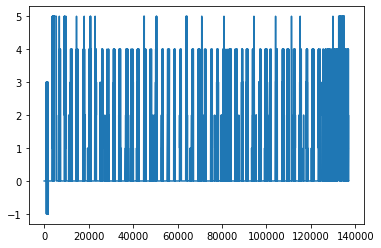

In [102]:
plt.plot(y_all)

In [103]:
y_pred_by_patient = []
y_by_patient = []
start = 0
for cnt in test_generator.list_cnt:
    y_pred_by_patient.append(y_pred_all[start:start+cnt])
    y_by_patient.append(y_all[start:start+cnt])
    start += cnt
    

In [104]:
confusion_matrix = np.zeros((n_classes,n_classes))
y = tf.cast(y, dtype=tf.int32)    
for i in range(n_classes):
    for j in range(n_classes):
        confusion_matrix[i,j] += np.sum((y_pred_all==i) * (y_all==j))

In [105]:
print('-'*20 + 'Confusion Matrix' + '-'*20)
for i in range(n_classes):
    print_ln = ""
    for j in range(n_classes):
        print_ln += "%.3f "%(confusion_matrix[i,j] / np.sum(confusion_matrix[i]))
    print(print_ln)
    
print('-'*20 + 'Confusion Matrix counts' + '-'*20)
for i in range(n_classes):
    print_ln = ""
    for j in range(n_classes):
        print_ln += "%d "%(confusion_matrix[i,j])
    print(print_ln)

--------------------Confusion Matrix--------------------
0.958 0.016 0.006 0.002 0.008 0.011 
0.275 0.366 0.197 0.004 0.156 0.001 
0.012 0.089 0.773 0.043 0.082 0.001 
0.009 0.024 0.265 0.672 0.029 0.000 
0.120 0.125 0.118 0.005 0.632 0.000 
0.917 0.000 0.083 0.000 0.000 0.000 
--------------------Confusion Matrix counts--------------------
84096 1386 490 185 673 955 
954 1270 683 13 541 5 
356 2593 22444 1261 2369 18 
53 146 1612 4087 179 1 
1234 1289 1219 52 6506 2 
11 0 1 0 0 0 


In [138]:
p_idx = 0
obs_len = 400

In [147]:
np.where(pred != gt)[0][0]

244

In [150]:
test_generator[batch_idx][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [151]:
tf.math.argmax(model(x_sample), axis=-1)

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [152]:
batch_idx, data_idx

(3, 52)

In [145]:
y_sample, y_pred_sample

(2, <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [156]:
diff[244]

-1

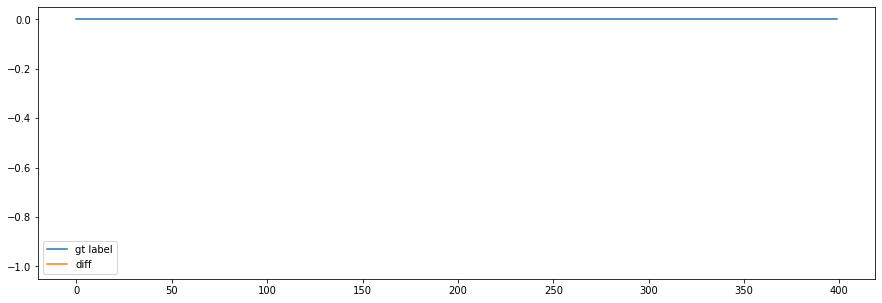

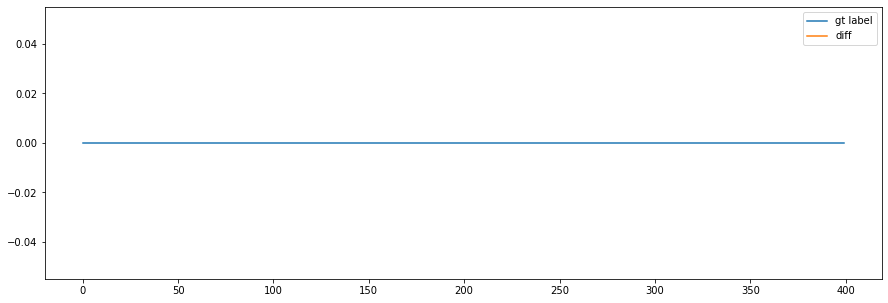

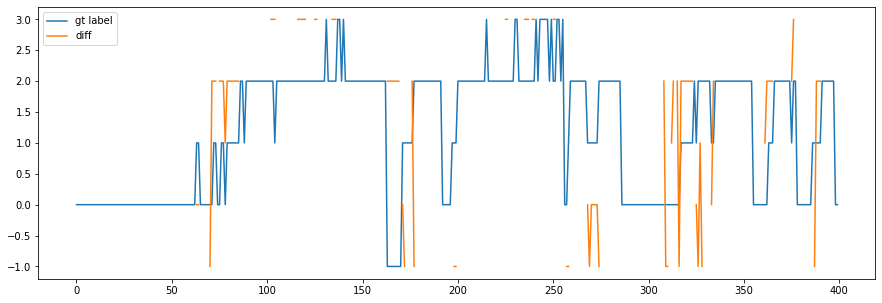

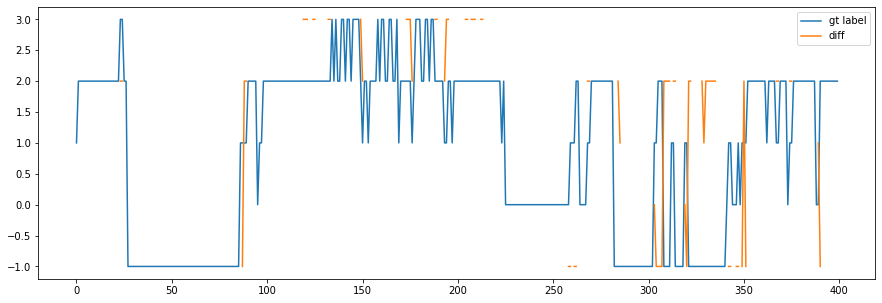

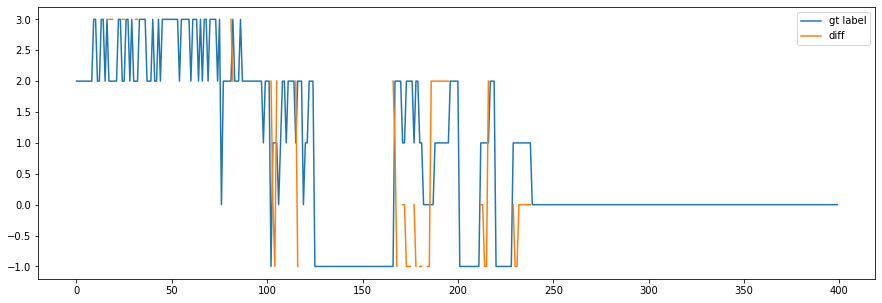

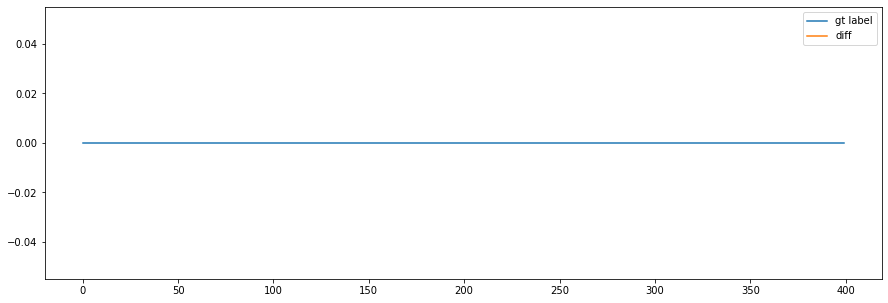

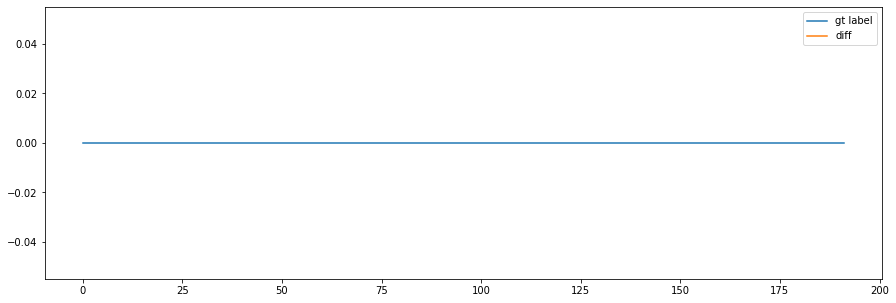

In [146]:
pred = y_pred_by_patient[p_idx]
gt = y_by_patient[p_idx]
pred[pred == 4] = -1
gt[gt == 4] = -1
diff = np.where(pred == gt, None, pred)
for i in range((len(pred - 10) - 1) // obs_len + 1):
    plt.figure(figsize=(15,5))
    plt.plot(gt[10 + obs_len * i:10 + obs_len * (i+1)], label='gt label')    
    plt.plot(diff[10 + obs_len * i:10 + obs_len * (i+1)], label='diff')
    plt.legend()

In [418]:
i = 274
batch_idx = np.where(pred != gt)[0][i] // bs
data_idx = np.where(pred != gt)[0][i] - batch_idx * bs
x_sample = test_generator[batch_idx][0]
y_sample = test_generator[batch_idx][1]
y_pred_sample = tf.math.argmax(model(x_sample), axis=-1)

In [419]:
gt[np.where(pred != gt)[0]]

array([ 0,  0,  0,  0,  1,  1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1,  1,  1,
        1,  1,  2,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  1,  1,
        2,  0,  0,  1,  1,  1,  1,  2,  0,  1,  1,  1,  1,  1,  3,  3, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,
        1,  2,  2,  2,  1,  3,  3,  3,  2,  2,  1,  1,  2,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  1,  0,  0,  0,  0,  1,  1,  2,  0,  1,  1,
        2, -1, -1, -1,  1,  1,  2,  2,  2, -1, -1, -1, -1,  1, -1, -1,  1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  0,  1,  1,
        1,  1,  1,  1,  1

In [420]:
pred[np.where(pred != gt)[0]]

array([-1, -1, -1, -1,  0,  0, -1,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  0, -1,
       -1,  2, -1,  1, -1, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3, -1, -1,  0, -1,  0,  0,  0,  0, -1,  3, -1,  2, -1, -1,
        1,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2,  0, -1,  1, -1,  0,  2,
       -1,  1,  2,  2,  2,  2,  2,  3,  1, -1,  2,  2,  2, -1,  2,  2,  2,
        2,  2,  2,  2,  1,  2,  2,  2,  2, -1,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  3,  3,
        0,  3,  3,  3,  2,  2,  2,  2,  3,  3,  2,  3,  3,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,
       -1,  2,  2,  1,  0, -1, -1, -1, -1,  2,  2,  2,  2,  2,  2,  2,  0,
       -1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1, -1,
        2, -1,  0,  2,  2

In [421]:
print("GT label:", y_sample[data_idx], " Predicted:", y_pred_sample[data_idx].numpy())

GT label: 2  Predicted: 1


(-5.0, 5.0)

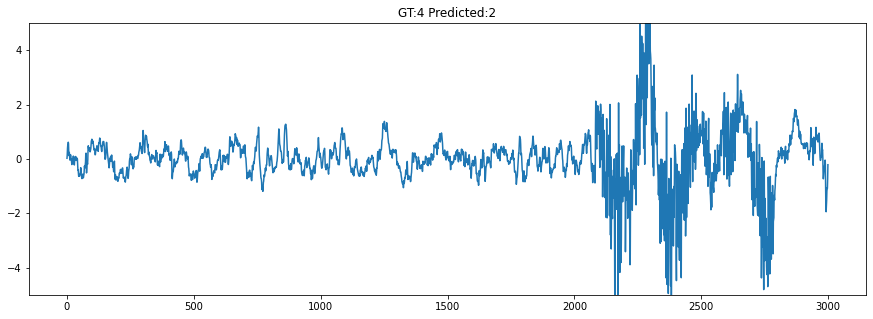

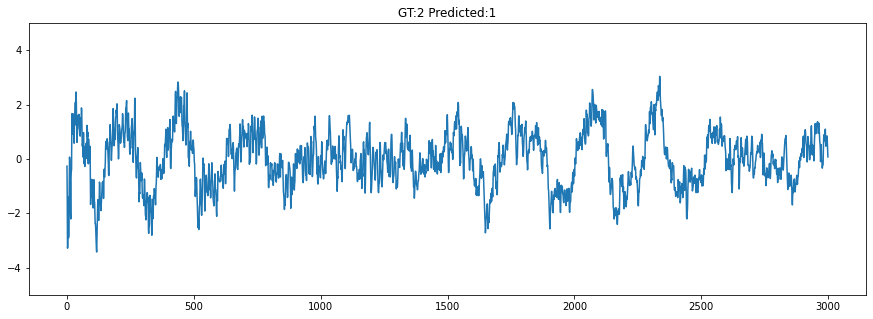

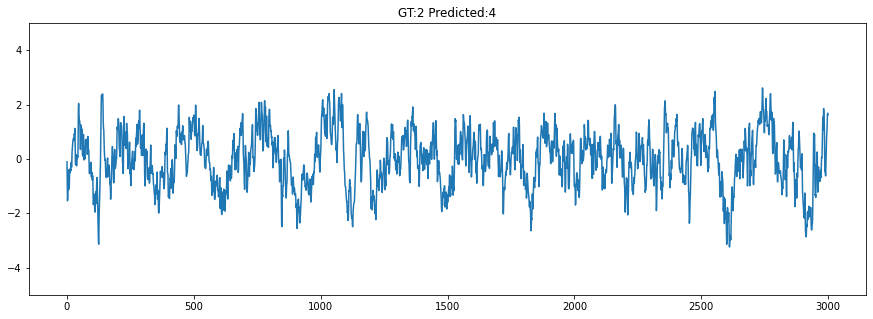

In [422]:
plt.figure(figsize=(15,5))
plt.plot(x_sample[data_idx-1])
plt.title("GT:" + str(y_sample[data_idx-1]) + " Predicted:" + str(y_pred_sample[data_idx-1].numpy()))
plt.ylim(-5,5)
plt.figure(figsize=(15,5))
plt.plot(x_sample[data_idx])
plt.ylim(-5,5)
plt.title("GT:" + str(y_sample[data_idx]) + " Predicted:" + str(y_pred_sample[data_idx].numpy()))
plt.figure(figsize=(15,5))
plt.title("GT:" + str(y_sample[data_idx+1]) + " Predicted:" + str(y_pred_sample[data_idx+1].numpy()))
plt.plot(x_sample[data_idx+1])
plt.ylim(-5,5)

In [412]:
17*16

272

In [406]:
model2 = nets.Conv1DASPP_multi(batch_size=bs, prev_cnt=PREV_CNT)

In [108]:
x2 = np.random.random((bs,PREV_CNT+1, 3000,1))
x2 = tf.convert_to_tensor(x2)
model2(x2)
print(model2.summary())

Model: "conv1daspp_multi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1daspp_layer_1 (Conv1DAS multiple                  3379456   
_________________________________________________________________
dense_3 (Dense)              multiple                  168966    
Total params: 3,548,422
Trainable params: 3,542,726
Non-trainable params: 5,696
_________________________________________________________________
None


In [105]:
ckpt2 = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=model2)
manager2 = tf.train.CheckpointManager(ckpt2, '../tf_ckpt/ckpt_' + model2.name, max_to_keep=1)

In [6]:
status = ckpt2.restore(tf.train.latest_checkpoint('../tf_ckpt/ckpt_' + model2.name))

NameError: name 'ckpt2' is not defined

In [106]:
if manager2.latest_checkpoint:
    ckpt2.restore(manager2.latest_checkpoint)
    start_epoch = ckpt2.step.numpy()-1

ValueError: Shapes (28160, 6) and (2560, 6) are incompatible

In [104]:
correct, total_cnt, total_loss = 0.0, 0.0, 0.0
start = time.time()
y_list2, y_pred_list2 = [], []
for idx, (x, y) in enumerate(test_generator2):
    y_pred = model2(x, training=False)
    y_pred_cls = tf.math.argmax(y_pred, axis=-1)
    y_pred_list2.append(y_pred_cls)
    correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
    total_cnt += y_pred.shape[0]
    y = tf.cast(y, dtype=tf.int32)  
    y_list2.append(y)
    total_loss += loss_fn(y, y_pred).numpy() * y_pred.shape[0]    

    test_acc = correct / total_cnt
    test_loss = total_loss / total_cnt
    if (idx + 1) % 10 == 0 or idx+1 == len(test_generator2):
        print("[%d / %d] test loss: %.6f, test accuracy: %.3f"%
              (idx+1, len(test_generator2), test_loss, test_acc),end='\r', flush=True)
print("")
print("Eval time: %.2f sec"%(time.time() - start))

KeyboardInterrupt: 